In [1]:
import pyspark
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import pyspark.ml.feature as ML
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
account_name = "REDACTED"
account_key = "REDACTED"

spark = (
    SparkSession
        .builder
        .master('local[*]')
        .appName("Ingestion")
        .config("spark.driver.memory", "4g")
        .config("fs.azure.account.auth.type." + account_name + ".dfs.core.windows.net", "SharedKey")
        .config("fs.azure.account.key." + account_name + ".dfs.core.windows.net", account_key)
        .getOrCreate()
)

sc = spark.sparkContext

In [3]:
container_name = 'data'
path_to_table = '/training/'

def readDataframeFromAdls(spark_session, container_name, path_to_table, table_name):
    return (
        spark_session
            .read.parquet(f"abfss://{container_name}@REDACTED.dfs.core.windows.net{path_to_table}{table_name}")
    ).drop('LEVEL')

In [4]:
df_training = readDataframeFromAdls(spark, container_name, path_to_table, 'df_training')

In [5]:
df_duplicates = df_training.drop_duplicates()

In [6]:
types = ['GSM','LTE','UNKNOWN','WCDMA']
gps_sources = ['FUSED', 'GPS','NET']
stypes = ['LOCATION' ,'NF_BOOST_TECHNOLOGY', 'NF_SERVICE', 'NF_BOOST_COVERAGE','TIMER', 'WORKER','UNKNOWN']
battery_states = ['CHARGING' ,'FULL', 'NOT_CHARGING','UNCHARGING', 'UNKNOWN']
activity_states = ['IN_VEHICLE','ON_BICYCLE','ON_FOOT','STILL','TILTING','WALKING', 'UNKNOWN']
times_of_day = ['MORNING', 'AFTERNOON', 'NIGHT']

In [7]:
def filterCategoricalFeatures(df, column_name, feature_list, else_value='UNKNOWN'):
    return (
        df.withColumn(column_name, 
            F.when(F.col(column_name).isin(feature_list), F.col(column_name))
            .otherwise(F.lit(else_value))
        )
    )

In [8]:
df_activity = filterCategoricalFeatures(df_duplicates, 'ACTIVITY_STATE', activity_states)
df_lag_activity = filterCategoricalFeatures(df_activity, 'LAG_ACTIVITY', activity_states)
df_lead_activity = filterCategoricalFeatures(df_lag_activity, 'LEAD_ACTIVITY', activity_states)
df_battery = filterCategoricalFeatures(df_lead_activity, 'BATT_CHARGE', battery_states)
df_stypes = filterCategoricalFeatures(df_battery, 'STYPE', stypes)
df_source = filterCategoricalFeatures(df_stypes, 'SOURCE', gps_sources)
df_types = filterCategoricalFeatures(df_source, 'TYPE', types)
df_time_day = filterCategoricalFeatures(df_types, 'TIME_DAY', times_of_day)

In [9]:
df_cast = (
    df_time_day
        .withColumn('WIFI_CONNECTED_INT', F.col('WIFI_CONNECTED').cast('int'))
        .withColumn('y', 
            F.when(
                (F.col('ENV_LABEL') == 'i'), 1
            ).otherwise(0)
        )
        .drop('WIFI_CONNECTED', 'ENV_LABEL')
)

In [10]:
df_cast.columns

['ACCURACY',
 'ACTIVITY_CONFID',
 'ACTIVITY_STATE',
 'BATT_CHARGE',
 'DISTANCE',
 'GPS_DELAY',
 'LAG_ACTIVITY',
 'LAG_LTIME',
 'LAG_SPEED',
 'LEAD_ACTIVITY',
 'LEAD_LTIME',
 'LEAD_SPEED',
 'LEVEL_MW',
 'LIGHT',
 'MAGNET_X',
 'MAGNET_Y',
 'MAGNET_Z',
 'PROXIMITY',
 'QUAL',
 'SOURCE',
 'SPEED',
 'STYPE',
 'TIME_DAY',
 'TYPE',
 'WEEKEND',
 'WIFI_CONNECTED_INT',
 'y']

In [11]:
median_imputer_input = ['LEVEL_MW', 'QUAL', 'GPS_DELAY', 'SPEED', 'DISTANCE', 'LIGHT', 'MAGNET_X', 'MAGNET_Y', 'MAGNET_Z', 'PROXIMITY']
median_imputer_output = [f'{col}_impute' for col in median_imputer_input]

string_indexer_input = ['STYPE', 'TYPE','SOURCE','BATT_CHARGE', 'ACTIVITY_STATE', 'LAG_ACTIVITY', 'LEAD_ACTIVITY', 'TIME_DAY']
string_indexer_output = [f'{col}_index' for col in string_indexer_input]

#one_hot_encoder_input = string_indexer_output + ['WIFI_CONNECTED_INT', 'WEEKEND']
one_hot_encoder_input = string_indexer_output
one_hot_encoder_output = [f'{col}_one_hot' for col in one_hot_encoder_input]

# Get all columns which aren't transformed 
remaining_cols = list(set(df_cast.columns) - set(median_imputer_input + string_indexer_input))
# Combine with transformed columns
all_columns = remaining_cols + median_imputer_output + one_hot_encoder_output
# Remove y
X_columns = sorted([col for col in all_columns if col not in ['y']])

In [12]:
X_columns

['ACCURACY',
 'ACTIVITY_CONFID',
 'ACTIVITY_STATE_index_one_hot',
 'BATT_CHARGE_index_one_hot',
 'DISTANCE_impute',
 'GPS_DELAY_impute',
 'LAG_ACTIVITY_index_one_hot',
 'LAG_LTIME',
 'LAG_SPEED',
 'LEAD_ACTIVITY_index_one_hot',
 'LEAD_LTIME',
 'LEAD_SPEED',
 'LEVEL_MW_impute',
 'LIGHT_impute',
 'MAGNET_X_impute',
 'MAGNET_Y_impute',
 'MAGNET_Z_impute',
 'PROXIMITY_impute',
 'QUAL_impute',
 'SOURCE_index_one_hot',
 'SPEED_impute',
 'STYPE_index_one_hot',
 'TIME_DAY_index_one_hot',
 'TYPE_index_one_hot',
 'WEEKEND',
 'WIFI_CONNECTED_INT']

In [13]:
median_imputer = (
    ML.Imputer(
        inputCols=median_imputer_input, 
        outputCols=median_imputer_output
    )
    .setStrategy("median")
)

In [14]:
df_imputed = median_imputer.fit(df_cast).transform(df_cast)

In [15]:
df_fill_numerical = df_imputed.fillna(-1)

In [16]:
string_indexer = (
    ML.StringIndexer(
        inputCols=string_indexer_input,
        outputCols=string_indexer_output,
    )
)

In [17]:
one_hot_encoder = (
    ML.OneHotEncoder(
        inputCols=one_hot_encoder_input,
        outputCols=one_hot_encoder_output,
    )
)

In [18]:
vector_assembler = (
    ML.VectorAssembler(
        inputCols=X_columns,
        outputCol='X'
    )
)

In [19]:
#Create pipeline and pass all stages
pipeline = (
        Pipeline(
                stages=[
                       string_indexer,
                       one_hot_encoder,
                       vector_assembler
                ]
        )
)

In [20]:
df_transformed = pipeline.fit(df_fill_numerical).transform(df_fill_numerical)

In [21]:
df_train, df_test = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [22]:
rfc = (
    RandomForestClassifier(
        labelCol='y',
        featuresCol='X'
    )
)

In [23]:
rfc_model = rfc.fit(df_train)

In [24]:
df_predictions = rfc_model.transform(df_test)

In [25]:
# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderROC')

# Get metrics
acc = evaluatorMulti.evaluate(df_predictions, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(df_predictions, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(df_predictions, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(df_predictions, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(df_predictions)

In [26]:
print(f'Accuracy: {acc}')
print(f'F1: {f1}')
print(f'Weighted Precision: {weightedPrecision}')
print(f'Weighted Recall: {weightedRecall}')
print(f'AUC: {auc}')

Accuracy: 0.9850185438219793
F1: 0.9850213362417602
Weighted Precision: 0.9850630310525411
Weighted Recall: 0.9850185438219794
AUC: 0.9851925311327641


In [27]:
y_true = df_predictions.select(['y']).collect()
y_pred = df_predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99     53604
           1       0.98      0.99      0.98     48856

    accuracy                           0.99    102460
   macro avg       0.98      0.99      0.98    102460
weighted avg       0.99      0.99      0.99    102460

[[52609   995]
 [  540 48316]]


In [28]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

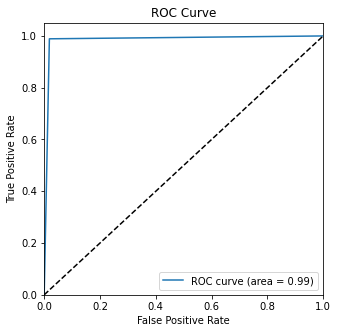

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
feature_importance = rfc_model.featureImportances

In [31]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [32]:
import pandas as pd
ExtractFeatureImp(feature_importance, df_train, "X").head(10)

,idx,name,score
16,40,SPEED_impute,0.199681
0,0,ACCURACY,0.148770
18,53,WIFI_CONNECTED_INT,0.133314
19,2,ACTIVITY_STATE_index_one_hot_STILL,0.127474
1,1,ACTIVITY_CONFID,0.127371
7,29,LEAD_SPEED,0.058309
20,3,ACTIVITY_STATE_index_one_hot_IN_VEHICLE,0.050069
30,15,LAG_ACTIVITY_index_one_hot_STILL,0.041923
29,14,LAG_ACTIVITY_index_one_hot_IN_VEHICLE,0.039991
35,22,LEAD_ACTIVITY_index_one_hot_IN_VEHICLE,0.012652


In [33]:
container_name = 'data'
path_to_table = '/model/'

def writeModelToAdls(model, container_name, path, name):
    (model
        .write()
        .save(f"abfss://{container_name}@05nclorenzst01.dfs.core.windows.net{path}{name}")
    )

In [34]:
writeModelToAdls(rfc_model, container_name, path_to_table, "rfc_model_2")